# Legal note

__As completing homework assignments is an inherent part of the course, I felt justified to re-use the code published in the course's GitHub repo in spite of its copyright.__

__Since I am only using this notebook (something that is encouraged in the task description) for homework, I think it is fair use.__

### Only did nontrivial modifications in the _MLP class_.

Péter Tamás Kovács, Neptun ID: SYB0HS 



# Copyright

<PRE>
Jelen iPython notebook a Budapesti Műszaki és Gazdaságtudományi Egyetemen tartott "Deep Learning a gyakorlatban Python és LUA alapon" tantárgy segédanyagaként készült. 
A tantárgy honlapja: http://smartlab.tmit.bme.hu/oktatas-deep-learning
Deep Learning kutatás: http://smartlab.tmit.bme.hu/deep-learning
Jelen notebook Nicolas P. Rougier munkája alapján készült, melyet BSD licensz véd: http://www.labri.fr/perso/nrougier/downloads/mlp.py

A notebook bármely részének újra felhasználása, publikálása csak a szerzők írásos beleegyezése esetén megegengedett.

2020 (c) Gyires-Tóth Bálint (toth.b kukac tmit pont bme pont hu), Császár Márk
</PRE>

# XOR feladat neuron hálós megközelítése

Először a historikisan is nagy jelentőségű XOR problémát fogjuk megoldani "pure" Python-ban. 

A XOR probléma a gépi tanulás szempontjából azért érdekes, mert míg az AND és az OR logikai függvények architektúrális szempontból megoldhatóak egyetlen neuron segítségével, addig a XOR-ra ez nem teljesül. Az AND és az OR esetében létezik a függvény által felveheto kimeneti értékek között egy olyan hipersík (szeparálósík), amely segítségével egyértelmű a szeparáció.

A XOR probléma további tárgyalásához tekintsük az alábbi igazságtáblát:


  A     | B   | A XOR B
  :----:| :----:|:--------:
  0     | 0   |    0
  1     | 0   |    1
  0     | 1   |    1
  1     | 1   |    0

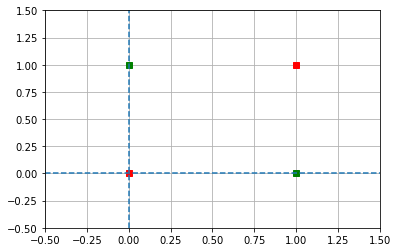

In [10]:
# A notebook alapú megjelenítés aktiválása
%matplotlib inline
import matplotlib.pyplot as plt # Pylab grafikus megjelenítocsomag importálása

# "Igaz" logikai értékek megadása
true_x = [1, 0]
true_y = [0, 1]

# "Hamis" logikai értékek megadása
false_x = [0, 1]
false_y = [0, 1]

# Jelöljük pirossal a hamis logikai értékeket, zölddel pedig az igazakat.
plot1 = plt.plot(true_x, true_y,'gs')
plot2 = plt.plot(false_x, false_y, 'rs')

# A jobb ábrázálhatóság miatt, szélesebb tartományokat jelenítünk meg
plt.xlim(-0.5, 1.5)
plt.ylim(-0.5, 1.5)

# Négyzetrács megjelenítése
plt.grid(True)

# Az x és y tengely megjelenítése
plt.axhline(0, linestyle='dashed')
plt.axvline(0, linestyle='dashed')

# Az ábra kirajzolása
plt.show()

Mint ahogy a fenti ábrán is látszódik, nem tudjuk egyetlen szeparáló síkkal (2 dimenzióban egyenessel) külön választani az igaz és a hamis értékeket.

Mivel egyetlen síkkal nem tudjuk szétválasztani a kimeneteket ezért a neurális hálózat be- és kimeneti rétege közé szükségszerű, hogy további, un. rejtett réteg(ek)et illesszünk be. 

Mielőtt a konkrét programkóddal ismerkednénk meg, tekintsük át egy mesterséges neurális hálózat általános architektúráját, felépítését. Ahhoz, hogy neurális hálózatunk felügyelt tanítás során rendeltetésszerűen működjön, szükségünk van:

 - Tanító adatokra (bemenet és felügyelt esetben kimenet),
 - Magára a neurális hálózatra, amely magában foglal:
   - bemeneti réteget, egy kimeneti réteget, illetve köztük elhelyezkedo rejtett réteg(ek)et,
   - rétegenként tetszőleges számú neuronokat, 
   - a rétegeket összekötő, különböző súlyokkal rendelkező éleket,
   - a neuronokon elvégzett lineáris (súlyozott összegzés), illetve nem lineáris függvényeket (pl. sigmoid, tanh, ReLU, stb.).
 - Tanítási fázist:
   - a bemenő adatokat "végigküldjük" a hálózaton (forward propagation),
   - a bemenő adatok alapján kiszámoljuk a hálózat által "jósolt" eredményt,
   - a jósolt eredmény és a tanító adatokban szereplő elvárt eredmény közötti kapcsolat kiszámítása (költségfüggvény),
   - a kapott hibaérték visszaterjesztése (backpropagation) a hálózaton, a láncszabály és a parciális deriválás módszerével (gradiensek kiszámítása)
   - a rétegek közötti súlyok frissítését a gradiensek segítségével.
   
Első lépésként importáljuk a már jól ismert Numpy csomagot, amire np-ként fogunk hivatkozni, illetve a további szükséges csomagokat:

In [11]:
import numpy as np
from sklearn import preprocessing
import copy

Az aktivációs függvény definiálása. A "forward" lépésben a hálózatot alkotó neuronokkal két műveletet hajtunk végre: (1) Egy súlyozott lineáris összegzést, (2) illetve egy nemlineáris aktiválási függvényt. A lineáris függvény nem csinál mást, minthogy összegzi az adott neuronhoz beérkező értékeket a hozzá vezető súly értékével megszorozva. Ezután a kapott eredményen alkalmazzuk a nemlineáris aktivációs függvényt. Ez általában annyit csinál, hogy amennyiben az argomentuma (a korábbi szummázás)meghalad egy bizonyos küszöbértéket, akkor a neuron továbbítja a következő rétegre az adatokat. Itt a sigmoid-ot használjuk erre a célra, amit előbb definiálunk majd megnézzük, hogy hogyan néz ki:

In [12]:
def activation(x):
    return 1 / (1 + np.exp(-x))

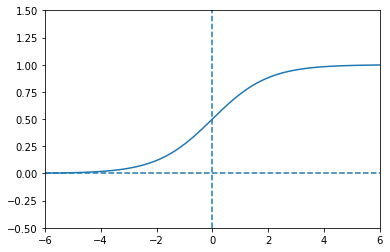

In [13]:
segedX=np.linspace(-6,6,200)
# A jobb ábrázálhatóság miatt, szélesebb tartományokat jelenítünk meg
plt.xlim(-6, 6)
plt.ylim(-0.5, 1.5)
# Az x és y tengely megjelenítése
plt.axhline(0, linestyle='dashed')
plt.axvline(0, linestyle='dashed')
plt.plot(segedX,activation(segedX))

Következőnek definiáljuk az aktivációs függvény deriváltját. A tanítási fázis során, a hiba végigterjesztésekor (backpropagation) az aktivációs függvényt, azaz annak a deriváltját használjuk. Definiáljuk majd nézzük meg ezt is, hogy hogyan néz ki sigmoid esetén:

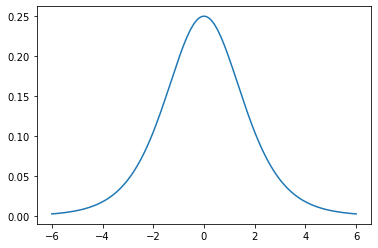

In [14]:
def dactivation(x):
    return np.exp(-x)/((1+np.exp(-x))**2)
plt.plot(segedX,dactivation(segedX))

Most jön a java! Definiáljuk az MLP osztályt négy függvénnyel: inicializálás, súlyok resetelése, forward lépés, backward lépés.

### HF2 modifications in this cell and the ones below - testing

In [38]:
class MLP:

    def __init__(self, *args):
       
        np.random.seed(123)

        self.shape = args
        n = len(args)
        
        self.layers = []
        
        self.layers.append(np.ones(self.shape[0]+1))
       
        for i in range(1,n):
            self.layers.append(np.ones(self.shape[i]))
        
        self.weights = []
        for i in range(n-1):
            self.weights.append(np.zeros((self.layers[i].size,
                                         self.layers[i+1].size)))
        
        self.dw = [0,]*len(self.weights)
       
        self.reset()
    
    
    def reset(self):
        for i in range(len(self.weights)):
             
            Z = np.random.random((self.layers[i].size,self.layers[i+1].size))
            
            self.weights[i][...] = (2*Z-1)*1

# HF2 - modifications start from here -----------------------------------------------------------------------

# HF2: auxiliary function for weight updating - computes the addintional term for all possibilities
    # optimizer_regularizer may take values from {None,'momentum','l1','l2'} 
    # hyperpm stands for the additional hyperparameter in optimizer_regularizer's formula from lecture slides
    

    def weight_updater_extension(self,layer_index,l_rate,optimizer_regularizer,hyperpm):
        
        if optimizer_regularizer=='momentum':
            if type(self.dw[layer_index])=='list': # first iteration, we don't have momentum yet 
                return np.zeros(self.weights[layer_index].shape,float)
            
            else:
# called before dw update!
                return hyperpm*self.dw[layer_index]
            
        elif optimizer_regularizer=='l1':
            return -1*l_rate*hyperpm*(2*(self.weights[layer_index]>0)-1) # handy way to implement sgn(.)
        
        elif optimizer_regularizer=='l2':
            return -1*l_rate*hyperpm*self.weights[layer_index]
        
        else: # None case
            return np.zeros(self.weights[layer_index].shape,float)

# HF2: end of auxiliary function ----------------------------------------------------------------------------
        
    def propagate_forward(self, data):
       
        self.layers[0][0:-1] = data
       
        for i in range(1,len(self.shape)):
            self.layers[i][...] = activation(np.dot(self.layers[i-1],self.weights[i-1]))
        
        return self.layers[-1]


    
    def propagate_backward(self, target, lrate=0.1, optimizer_regularizer=None,hyperpm=0):
        deltas = []
        error = -(target-self.layers[-1])
        
        delta = np.multiply(error,dactivation(np.dot(self.layers[-2],self.weights[-1])))
        deltas.append(delta)
        
        for i in range(len(self.shape)-2,0,-1):
       
            delta=np.dot(deltas[0],self.weights[i].T)*dactivation(np.dot(self.layers[i-1],self.weights[i-1]))
            deltas.insert(0,delta)            
       
        for i in range(len(self.weights)):
            layer = np.atleast_2d(self.layers[i])
            delta = np.atleast_2d(deltas[i])

# HF2: insertion of the new weight update mechanisms --------------------------------------------------------
            
            dw = -lrate*np.dot(layer.T,delta)+self.weight_updater_extension(i,lrate,optimizer_regularizer,hyperpm)

# HF2: end of insertion -------------------------------------------------------------------------------------

            self.weights[i] += dw 

           
            self.dw[i] = dw

        return (error**2).sum()

### Below I only modified the code to be able to test backprop with the new parameters

In [33]:
#HF2: add new arguments to signature --------------------------------------------------------

def learn(network, X, Y, valid_split, test_split, epochs=20, lrate=0.1, optimizer_regularizer=None,hyperpm=0):

#--------------------------------------------------------------------------------------------
        
        X_train = X[0:int(nb_samples*(1-valid_split-test_split))]
        Y_train = Y[0:int(nb_samples*(1-valid_split-test_split))]
        X_valid = X[int(nb_samples*(1-valid_split-test_split)):int(nb_samples*(1-test_split))]
        Y_valid = Y[int(nb_samples*(1-valid_split-test_split)):int(nb_samples*(1-test_split))]
        X_test  = X[int(nb_samples*(1-test_split)):]
        Y_test  = Y[int(nb_samples*(1-test_split)):]
    
        scaler = preprocessing.StandardScaler().fit(X_train)
        X_train = scaler.transform(X_train)
        X_valid = scaler.transform(X_valid)
        X_test  = scaler.transform(X_test)
    
        
        randperm = np.random.permutation(len(X_train))
        X_train, Y_train = X_train[randperm], Y_train[randperm]
        
       
        for i in range(epochs):
           
            train_err = 0
            for k in range(X_train.shape[0]):
                network.propagate_forward( X_train[k] )
                
# HF2: add new parameters to backprop call ---------------------------------------------------           

                train_err += network.propagate_backward( Y_train[k], lrate ,optimizer_regularizer,hyperpm)
#---------------------------------------------------------------------------------------------

            train_err /= X_train.shape[0]

            
            valid_err = 0
            o_valid = np.zeros(X_valid.shape[0])
            for k in range(X_valid.shape[0]):
                o_valid[k] = network.propagate_forward(X_valid[k])
                valid_err += (o_valid[k]-Y_valid[k])**2
            valid_err /= X_valid.shape[0]

            print("%d epoch, train_err: %.4f, valid_err: %.4f" % (i, train_err, valid_err))

        
        print("\n--- TESZTELÉS ---\n")
        test_err = 0
        o_test = np.zeros(X_test.shape[0])
        for k in range(X_test.shape[0]):
            o_test[k] = network.propagate_forward(X_test[k])
            test_err += (o_test[k]-Y_test[k])**2
            print(k, X_test[k], '%.2f' % o_test[k], ' (elvart eredmeny: %.2f)' % Y_test[k])
        test_err /= X_test.shape[0]

        fig1=plt.figure()
        plt.scatter(X_test[:,0], X_test[:,1], c=np.round(o_test[:]), cmap=plt.cm.cool)

In [39]:
# Mesterséges neurális hálózat létrehozása, 2 bemenettel, 10 rejtett neuronnal és 1 kimenettel
network = MLP(2,10,1)

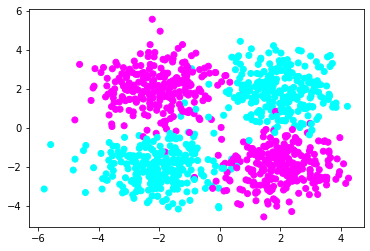

In [40]:
# Tanító, validációs és teszt adatok megadása a rendszernek (zajjal terhelt XOR adatok)
nb_samples=1000
X = np.zeros((nb_samples,2))
Y = np.zeros(nb_samples)
for i in range(0,nb_samples,4):
    noise = np.random.normal(0,1,8)
    X[i], Y[i] = (-2+noise[0],-2+noise[1]), 0
    X[i+1], Y[i+1] = (2+noise[2],-2+noise[3]), 1
    X[i+2], Y[i+2] = (-2+noise[4],2+noise[5]), 1
    X[i+3], Y[i+3] = (2+noise[6],2+noise[7]), 0

# ...és az adatok kirajzolása
fig1=plt.figure()
plt.scatter(X[:,0],X[:,1],c=Y[:], cmap=plt.cm.cool)

### Using the original test code, I tried all optimizer options I just coded

0 epoch, train_err: 0.2461, valid_err: 0.2378
1 epoch, train_err: 0.2297, valid_err: 0.2212
2 epoch, train_err: 0.2070, valid_err: 0.1934
3 epoch, train_err: 0.1742, valid_err: 0.1585
4 epoch, train_err: 0.1387, valid_err: 0.1267
5 epoch, train_err: 0.1098, valid_err: 0.1035
6 epoch, train_err: 0.0897, valid_err: 0.0879
7 epoch, train_err: 0.0764, valid_err: 0.0773
8 epoch, train_err: 0.0673, valid_err: 0.0700
9 epoch, train_err: 0.0610, valid_err: 0.0647
10 epoch, train_err: 0.0564, valid_err: 0.0606
11 epoch, train_err: 0.0529, valid_err: 0.0575
12 epoch, train_err: 0.0502, valid_err: 0.0551
13 epoch, train_err: 0.0480, valid_err: 0.0531
14 epoch, train_err: 0.0462, valid_err: 0.0514
15 epoch, train_err: 0.0447, valid_err: 0.0500
16 epoch, train_err: 0.0434, valid_err: 0.0488
17 epoch, train_err: 0.0422, valid_err: 0.0477
18 epoch, train_err: 0.0413, valid_err: 0.0468
19 epoch, train_err: 0.0404, valid_err: 0.0460

--- TESZTELÉS ---

0 [-0.49551261 -0.7444607 ] 0.18  (elvart eredmeny

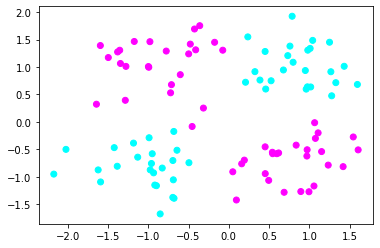

In [41]:
# Tanítás/Tesztelés indítása
network.reset()
learn(network, X, Y, 0.2, 0.1,epochs=20,optimizer_regularizer=None,hyperpm=0)

0 epoch, train_err: 0.2574, valid_err: 0.2486
1 epoch, train_err: 0.2514, valid_err: 0.2451
2 epoch, train_err: 0.2466, valid_err: 0.2392
3 epoch, train_err: 0.2377, valid_err: 0.2277
4 epoch, train_err: 0.2208, valid_err: 0.2071
5 epoch, train_err: 0.1934, valid_err: 0.1770
6 epoch, train_err: 0.1586, valid_err: 0.1439
7 epoch, train_err: 0.1252, valid_err: 0.1160
8 epoch, train_err: 0.0996, valid_err: 0.0963
9 epoch, train_err: 0.0822, valid_err: 0.0831
10 epoch, train_err: 0.0706, valid_err: 0.0742
11 epoch, train_err: 0.0626, valid_err: 0.0680
12 epoch, train_err: 0.0569, valid_err: 0.0634
13 epoch, train_err: 0.0527, valid_err: 0.0599
14 epoch, train_err: 0.0494, valid_err: 0.0572
15 epoch, train_err: 0.0469, valid_err: 0.0550
16 epoch, train_err: 0.0448, valid_err: 0.0532
17 epoch, train_err: 0.0432, valid_err: 0.0517
18 epoch, train_err: 0.0418, valid_err: 0.0505
19 epoch, train_err: 0.0406, valid_err: 0.0494

--- TESZTELÉS ---

0 [-0.49551261 -0.7444607 ] 0.10  (elvart eredmeny

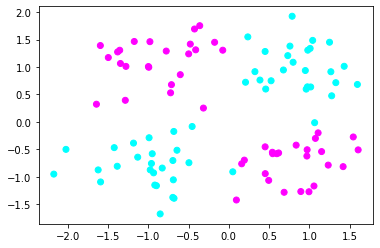

In [42]:
network.reset()
learn(network, X, Y, 0.2, 0.1,epochs=20,optimizer_regularizer='momentum',hyperpm=0.05)

0 epoch, train_err: 0.2591, valid_err: 0.2497
1 epoch, train_err: 0.2515, valid_err: 0.2475
2 epoch, train_err: 0.2498, valid_err: 0.2459
3 epoch, train_err: 0.2479, valid_err: 0.2436
4 epoch, train_err: 0.2450, valid_err: 0.2399
5 epoch, train_err: 0.2400, valid_err: 0.2337
6 epoch, train_err: 0.2319, valid_err: 0.2244
7 epoch, train_err: 0.2206, valid_err: 0.2120
8 epoch, train_err: 0.2062, valid_err: 0.1969
9 epoch, train_err: 0.1888, valid_err: 0.1788
10 epoch, train_err: 0.1685, valid_err: 0.1584
11 epoch, train_err: 0.1471, valid_err: 0.1385
12 epoch, train_err: 0.1276, valid_err: 0.1218
13 epoch, train_err: 0.1119, valid_err: 0.1090
14 epoch, train_err: 0.0999, valid_err: 0.0995
15 epoch, train_err: 0.0909, valid_err: 0.0923
16 epoch, train_err: 0.0840, valid_err: 0.0869
17 epoch, train_err: 0.0788, valid_err: 0.0827
18 epoch, train_err: 0.0746, valid_err: 0.0793
19 epoch, train_err: 0.0713, valid_err: 0.0766

--- TESZTELÉS ---

0 [-0.49551261 -0.7444607 ] 0.17  (elvart eredmeny

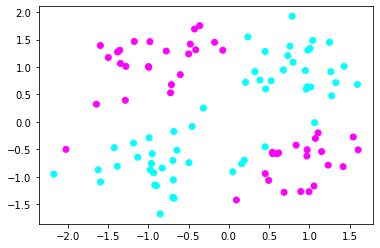

In [46]:
network.reset()
learn(network, X, Y, 0.2, 0.1,epochs=20,optimizer_regularizer='l1',hyperpm=0.0005)

0 epoch, train_err: 0.2567, valid_err: 0.2510
1 epoch, train_err: 0.2479, valid_err: 0.2461
2 epoch, train_err: 0.2434, valid_err: 0.2407
3 epoch, train_err: 0.2365, valid_err: 0.2321
4 epoch, train_err: 0.2251, valid_err: 0.2181
5 epoch, train_err: 0.2072, valid_err: 0.1982
6 epoch, train_err: 0.1840, valid_err: 0.1751
7 epoch, train_err: 0.1598, valid_err: 0.1536
8 epoch, train_err: 0.1390, valid_err: 0.1366
9 epoch, train_err: 0.1232, valid_err: 0.1241
10 epoch, train_err: 0.1119, valid_err: 0.1152
11 epoch, train_err: 0.1038, valid_err: 0.1087
12 epoch, train_err: 0.0979, valid_err: 0.1040
13 epoch, train_err: 0.0935, valid_err: 0.1003
14 epoch, train_err: 0.0901, valid_err: 0.0973
15 epoch, train_err: 0.0874, valid_err: 0.0949
16 epoch, train_err: 0.0851, valid_err: 0.0929
17 epoch, train_err: 0.0832, valid_err: 0.0910
18 epoch, train_err: 0.0814, valid_err: 0.0894
19 epoch, train_err: 0.0799, valid_err: 0.0879

--- TESZTELÉS ---

0 [-0.49551261 -0.7444607 ] 0.18  (elvart eredmeny

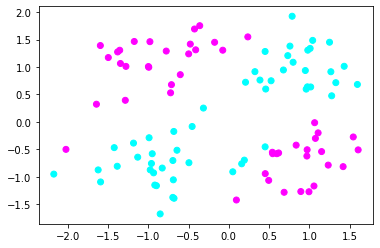

In [48]:
network.reset()
learn(network, X, Y, 0.2, 0.1,epochs=20,optimizer_regularizer='l2',hyperpm=0.0005)